# 4. Shear viscosity modeling of the Lennard-Jones fluid

This notebook is part of the Supporting Information of the article *Simulation and data-driven modeling of the transport properties of the Mie fluid* by Gustavo Chaparro and Erich A. Müller. (Submitted to Journal of Physical Chemistry B).

This work aims to compute and model the self diffusivity ($D^*$), shear viscosity ($\eta^*$), and thermal conductivity ($\kappa^*$) of systems of particles interacting through the Mie potential:

$$ \frac{\mathcal{U}^{Mie}}{\epsilon} = \underbrace{\left[ \frac{\lambda_r}{\lambda_r- \lambda_a} \left( \frac{\lambda_r}{\lambda_a}\right)^{\frac{\lambda_a}{\lambda_r - \lambda_a}}   \right]}_{\mathcal{C}^{Mie}} \left[ \left(\frac{\sigma}{r}\right)^{\lambda_r} -  \left(\frac{\sigma}{r}\right)^{\lambda_a} \right] $$ 

Here, $\mathcal{U}^{Mie}$ is the interaction energy between two particles, $\epsilon$ is the interaction energy well depth, $\sigma$ is the length scale, loosely associated to the effective particle diameter, and $r$ is the center-to-center distance between two Mie particles. Finally, $\lambda_r$ and $\lambda_a$ are the repulsive and attractive exponents, respectively. This work uses reduced units in which the Boltzmann constant ($k_b$), potential well depth ($\epsilon$), the shape parameter ($\sigma$), and Mie particle mass ($M$) are set to unity.

This notebook shows how to use the trained ANN models for the shear viscosity of the the Mie Fluid. This notebook relies on the following packages:
- Numpy (tested on version 1.24.2)
- jax (tested on version 0.4.4)
- flax (tested on version 0.6.6)
- nest_asyncio
- tp_modeling (Package containing the Transport Properties and Helmholtz models based on ANN using JAX and Flax)
- matplotlib (tested on version 3.6.3)
- pandas (tested on version 1.5.3)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tp_modeling import helper_get_alpha # helper function to get alpha_vdw value of a Mie Fluid
from tp_modeling import TransportModel_PVT # Transport model for the Mie Fluid (TP = ANN(alpha, rho, T))
from tp_modeling import TransportModel_PVT_Tinv # Transport model for the Mie Fluid (TP = ANN(alpha, rho, 1/T))
from tp_modeling import TransportModel_entropy # Transport model for the Mie Fluid  based on entropy scaling (TP = ANN(alpha, S^res))
from tp_modeling import TransportModelResidual_PVT_Tinv # Transport model for the Mie Fluid (TP = TP[1] + [ANN(alpha, rho, 1/T) -  ANN(alpha, rho=0., 1/T)])
from tp_modeling import viscosity_mie6_dilute # dilute gas approximations for diffusivity, viscosity and thermal conductivity
from tp_modeling import linear_activation

# some JAX/FLax imports
from jax import numpy as jnp
from jax.config import config
from flax.training import checkpoints
from flax.core import freeze
from flax import linen as nn
import nest_asyncio
nest_asyncio.apply()

# seeting up the precission to float64
PRECISSION = 'float64'
if PRECISSION == 'float64':
    config.update("jax_enable_x64", True)
    type_np = np.float64
    type_jax = jnp.float64
else:
    config.update("jax_enable_x32", True)
    type_np = np.float32
    type_jax = jnp.float32

The database is loaded as follows:

In [2]:
# Reading the viscosity database
path_to_data = '../databases/miefluid-visc.csv'
df_visc = pd.read_csv(path_to_data)
df_visc.head()

,lr,la,rho*,T*,rho*_sim,T*_sim,P*_sim,TotEn_sim,shear_viscosity,T*_sim_std,P*_sim_std,TotEn_sim_std,shear_viscosity_std
0,7.0,6.0,0.025000,8.69,0.025000,8.690745,0.219407,12.854953,0.650094,0.002926,0.000322,0.000050,0.028881
1,7.0,6.0,0.030000,1.52,0.030000,1.519069,0.038869,1.913550,0.136246,0.003726,0.000156,0.000048,0.004758
2,7.0,6.0,0.030000,8.79,0.030000,8.790500,0.266957,12.970099,0.678241,0.003259,0.000422,0.000027,0.004066
3,7.0,6.0,0.030000,10.00,0.030000,9.999401,0.304480,14.795203,0.737231,0.003575,0.000475,0.000051,0.070218
4,7.0,6.0,0.036876,1.84,0.036876,1.840098,0.058940,2.344216,0.182485,0.003744,0.000231,0.000049,0.007109


The model for the shear viscosity is loaded as follows:

In [3]:
#####################################
# LOADING THE SHEAR VISCOSITY MODEL #
#####################################

# Folder where the model are stored
save_dir = '../models/shear-viscosity'
# Name of the model
model_name = "logvisc-rho-Tinv-penalty-supcrit"
prefix_tp = f'{model_name}-params'
step = None
# Loading the model
state_restored = checkpoints.restore_checkpoint(save_dir, target=None, prefix=prefix_tp)
tp_activation = state_restored['activation']
tp_features = list(state_restored['features'].values())

# Infering the model type
if 'residual' in model_name:
    TPModel = TransportModelResidual_PVT_Tinv
elif 'Tinv' in model_name:
    TPModel = TransportModel_PVT_Tinv
elif 'entropy' in model_name:
    TPModel = TransportModel_entropy
else:
    TPModel = TransportModel_PVT

# Getting the output activation function
if tp_activation == 'linear':
    output_activation = linear_activation
elif tp_activation == 'softplus':
    output_activation = nn.softplus

# ANN model
visc_model = TPModel(features=tp_features, output_activation=output_activation)
# ANN parameters
visc_params = freeze({'params': state_restored['params']})

Now that the database and shear visocisty models are available, the data and the model can be compared. In this notebook, we will exemplify the results for the Lennard-Jones fluid ($\lambda_r=12$ and $\lambda_a=6$). First, we set up the exponents to variables and compute the $\alpha_{vdw}$ parameter. 

$$\alpha_{vdw} =  \mathcal{C}^{Mie} \left[ \frac{1}{\lambda_a - 3} - \frac{1}{\lambda_r - 3}\right]$$

The `helper_get_alpha` function computes this parameter.

In [4]:
# setting up the exponets of the Lennard-Jones fluid
lambda_r = 12
lambda_a = 6
# getting the alpha_vdw value
alpha_aux = helper_get_alpha(lambda_r, lambda_a)


The database can also be filtered just to have the data of the Lennard-Jones fluid.

In [5]:
# filtering the database to get only the Lennard-Jones fluid result.
filter_lr = df_visc['lr'] == lambda_r
filter_la = df_visc['la'] == lambda_a
df_lr12 = df_visc[filter_lr & filter_la].copy().reset_index(drop=True)
df_lr12.head()

,lr,la,rho*,T*,rho*_sim,T*_sim,P*_sim,TotEn_sim,shear_viscosity,T*_sim_std,P*_sim_std,TotEn_sim_std,shear_viscosity_std
0,12.0,6.0,0.020,6.13,0.020,6.130550,0.124404,9.099506,0.770639,0.001808,0.000234,0.000009,0.064620
1,12.0,6.0,0.025,8.14,0.025,8.140108,0.208143,12.104549,0.536924,0.002423,0.000409,0.000050,0.019830
2,12.0,6.0,0.030,4.87,0.030,4.869519,0.148463,7.148774,0.424860,0.002053,0.000370,0.000009,0.013577
3,12.0,6.0,0.030,6.16,0.030,6.160307,0.188974,9.097483,0.444530,0.002285,0.000436,0.000011,0.026069
4,12.0,6.0,0.030,10.00,0.030,10.001228,0.309127,14.890771,0.610114,0.003126,0.000648,0.000046,0.035173


Now, we will use the `visc_model.apply` method to obtain the predicted $\ln(\eta^*)$ by the ANN model. This function requires the arrays $\alpha_{vdw}$, $\rho^*$, and $T^*$. In this example, we will compute the results for five different isotherms.

In [6]:
# setting up the temperatures to plot
T1 = 0.9
T2 = 1.0
T3 = 1.3
T4 = 2.8
T5 = 6.0

# setting up the arrays to compute the transport property
n = 100
rho_plot = np.linspace(0.0, 1.2, n)
alpha_plot = np.ones(n) * alpha_aux
T1_plot = np.ones(n) * T1
T2_plot = np.ones(n) * T2
T3_plot = np.ones(n) * T3
T4_plot = np.ones(n) * T4
T5_plot = np.ones(n) * T5

# computing the shear viscosity
# remember this models gives you ln(visc)
lnvisc_T1_model = visc_model.apply(visc_params, alpha_plot, rho_plot, T1_plot) 
lnvisc_T2_model = visc_model.apply(visc_params, alpha_plot, rho_plot, T2_plot) 
lnvisc_T3_model = visc_model.apply(visc_params, alpha_plot, rho_plot, T3_plot) 
lnvisc_T4_model = visc_model.apply(visc_params, alpha_plot, rho_plot, T4_plot) 
lnvisc_T5_model = visc_model.apply(visc_params, alpha_plot, rho_plot, T5_plot) 

2024-01-17 16:41:14.579744: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none


The results can be plotted and compared against the molecular dynamics results.

Text(0.5, 1.0, 'Shear viscosity of Mie fluid: $\\lambda_r$ = 12, $\\lambda_a$ = 6')

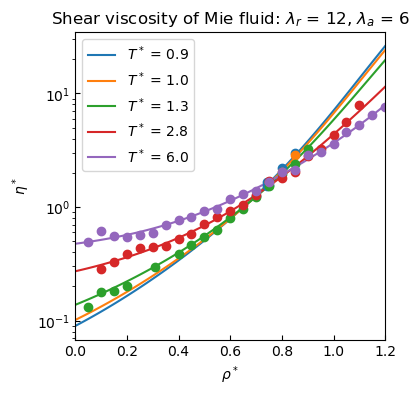

In [7]:
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111)

# plotting the self diffusivity results from the ANN model
ax1.plot(rho_plot, np.exp(lnvisc_T1_model), label=f'$T^*$ = {T1}', color='C0')
ax1.plot(rho_plot, np.exp(lnvisc_T2_model), label=f'$T^*$ = {T2}', color='C1')
ax1.plot(rho_plot, np.exp(lnvisc_T3_model), label=f'$T^*$ = {T3}', color='C2')
ax1.plot(rho_plot, np.exp(lnvisc_T4_model), label=f'$T^*$ = {T4}', color='C3')
ax1.plot(rho_plot, np.exp(lnvisc_T5_model), label=f'$T^*$ = {T5}', color='C4')

filter_T1 = df_lr12['T*'] == T1
filter_T2 = df_lr12['T*'] == T2
filter_T3 = df_lr12['T*'] == T3
filter_T4 = df_lr12['T*'] == T4
filter_T5 = df_lr12['T*'] == T5

# plotting the shear viscosity results from the database
ax1.plot(df_lr12[filter_T1]['rho*'], df_lr12[filter_T1]['shear_viscosity'], 'o', color='C0')
ax1.plot(df_lr12[filter_T2]['rho*'], df_lr12[filter_T2]['shear_viscosity'], 'o', color='C1')
ax1.plot(df_lr12[filter_T3]['rho*'], df_lr12[filter_T3]['shear_viscosity'], 'o', color='C2')
ax1.plot(df_lr12[filter_T4]['rho*'], df_lr12[filter_T4]['shear_viscosity'], 'o', color='C3')
ax1.plot(df_lr12[filter_T5]['rho*'], df_lr12[filter_T5]['shear_viscosity'], 'o', color='C4')

ax1.legend()
ax1.set_yscale('log')
ax1.set_xlim([0.0, 1.2])
# ax1.set_ylim([0.0, 0.8])
ax1.tick_params(direction='in')
ax1.set_xlabel(r'$\rho^*$')
ax1.set_ylabel(r'$\eta^*$')
ax1.set_title(f'Shear viscosity of Mie fluid: $\lambda_r$ = {lambda_r}, $\lambda_a$ = {lambda_a}')